# 1ère partie: Construction d'un modèle de Reconnaissance Automatique de la Parole (ASR)

In [3]:
!pip install transformers


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install torchaudio


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
!pip install librosa


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
!pip install huggingface_hub


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


#### Importation des librairies nécessaires

In [7]:
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch

#### Configuration du modèle et de l'appareil

In [8]:
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-french"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cpu


#### Chargement du modèle et du processeur pré-entraînés

In [9]:
print(f"Chargement du modèle et du processeur depuis {model_name}...")
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)

Chargement du modèle et du processeur depuis jonatasgrosman/wav2vec2-large-xlsr-53-french...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


#### Fonction pour charger et prétraiter le fichier audio

In [10]:
def load_and_preprocess_audio(file_path):
    """
    Charge et prétraite un fichier audio en le rééchantillonnant à 16 kHz.

    Args:
        file_path (str): Chemin vers le fichier audio à charger.

    Returns:
        numpy.ndarray: Tableau numpy contenant les données audio échantillonnées à 16 kHz.
    """
    # Charger l'audio à 16 kHz
    speech_array, _ = librosa.load(file_path, sr=16_000)
    return speech_array

#### Fonction pour prédire la transcription de l'audio

In [11]:
def predict_transcription(speech_array):
    """
    Prédire la transcription à partir d'une séquence audio.

    Args:
        speech_array (numpy.ndarray): Tableau numpy contenant les données audio prétraitées.

    Returns:
        str: La transcription textuelle prédite pour l'audio fourni.
    """
    # Préparer les inputs pour le modèle
    inputs = processor(speech_array, sampling_rate=16_000, return_tensors="pt", padding=True)

    # Transférer les inputs sur le bon device (GPU ou CPU)
    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Effectuer la prédiction sans gradient (inférence)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    # Décoder les prédictions pour obtenir le texte transcrit
    pred_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(pred_ids)[0]
    
    return transcription

#### Transcription l'audio

In [12]:
file_path = "C:/Users/USER/Documents/Audacity/dit.wav"  
speech_array = load_and_preprocess_audio(file_path)
transcription = predict_transcription(speech_array)
print("Transcription:", transcription)

Transcription: bonjour je suis content davoir étudié à did


# 2ème Partie: Analyse de polarity sur la transcription générée par le modèle ASR

#### Importation des bibliothèques nécessaires

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AutoTokenizer
from huggingface_hub import PyTorchModelHubMixin
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Definition des classes du Dataset et du Modèle

In [14]:
class AllocineReviewsDataset(Dataset):
    def __init__(
        self,
        csv_file,
        device,
        model_name_or_path="camembert-base",
        max_length= 128
    ):
        self.device = device
        self.df = pd.read_csv(csv_file)
        self.labels = self.df.polarity.unique()
        labels_dict = dict()
        for indx, l in enumerate(self.labels):
            labels_dict[l] = indx
        
        self.df["polarity"] = self.df["polarity"].map(labels_dict)
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name_or_path)

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        review_text = self.df.review[index]
        label_review = self.df.polarity[index]

        inputs = self.tokenizer(
            review_text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        labels = torch.tensor(label_review)

        return {
            "input_ids": inputs["input_ids"].squeeze(0).to(self.device),
            "attention_mask": inputs["attention_mask"].squeeze(0).to(self.device),
            "labels": labels.to(self.device)
        }
    

class SentimentAnalysisBert(nn.Module):
    def __init__(self, model_name_or_path="camembert-base", n_classes=2):
        super(SentimentAnalysisBert, self).__init__()
        self.Camembert_pretained = CamembertForSequenceClassification.from_pretrained(model_name_or_path, num_labels=n_classes)
        

    def forward(self, input_ids, attention_mask):
        x=self.Camembert_pretained(input_ids=input_ids, attention_mask=attention_mask).logits


        return x    

#### Entrainement du modèle

In [15]:
def training_step(model, train_loader, loss_fn, optimizer):
    model.train()

    total_loss = 0

    for data in tqdm(train_loader, total=len(train_loader)):

        input_ids = data["input_ids"]
        attention_mask = data["attention_mask"]
        labels = data["labels"]

        output = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

#### Evaluation du modèle

In [16]:
def evaluation_step(model, test_loader, loss_fn):
    model.eval()

    correct_predictions= 0
    losses=[]
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            input_ids = data["input_ids"]
            attention_mask = data["attention_mask"]
            labels = data["labels"]

            output = model(input_ids, attention_mask=attention_mask)

            _, pred = output.max(1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_predictions += torch.sum(pred==labels)

            loss = loss_fn(output, labels)

            losses.append(loss.item())


    return np.mean(losses) , correct_predictions /len(test_loader.dataset), all_preds, all_labels

#### Fonction d'analyse de sentiment

In [17]:
def analyze_sentiment(model, tokenizer, text, device):
    """
    Analyse le sentiment d'une transcription textuelle.

    Args:
        model: Modèle CamembertBert pré-entraîné pour l'analyse de sentiment.
        tokenizer: Tokenizer associé au modèle Bert.
        text (str): La transcription textuelle dont le sentiment doit être analysé.
        device (torch.device): L'appareil à utiliser pour l'inférence (CPU ou GPU).

    Returns:
        str: Le sentiment prédit ("positive" ou "negative").
    """
    model.eval()

    # Tokenisation du texte
    inputs = tokenizer(
        text,
        padding="max_length",
        max_length=100,
        truncation=True,
        return_tensors="pt"
    )

    # Préparer les inputs pour le modèle
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Effectuer la prédiction sans gradient (inférence)
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # Appliquer softmax pour obtenir les probabilités
    probs = torch.softmax(logits, dim=1)

    # Prendre l'index de la probabilité maximale pour obtenir la classe prédite
    pred_class = torch.argmax(probs, dim=1).cpu().item()

    # Mapper l'index de classe à une étiquette (positive/negative)
    sentiment = "positive" if pred_class == 1 else "negative"
    
    return sentiment

Training ...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\USER\AppData\Lo

Train Loss : 0.010839022696018219 | Eval Loss : 0.6971807479858398 | Accuracy : 0.4000000059604645


100%|██████████| 1/1 [00:14<00:00, 14.38s/it]


Train Loss : 0.010793349891901016 | Eval Loss : 0.6975369453430176 | Accuracy : 0.32499998807907104


100%|██████████| 1/1 [00:12<00:00, 12.26s/it]


Train Loss : 0.01073946598917246 | Eval Loss : 0.6981980800628662 | Accuracy : 0.3499999940395355


100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


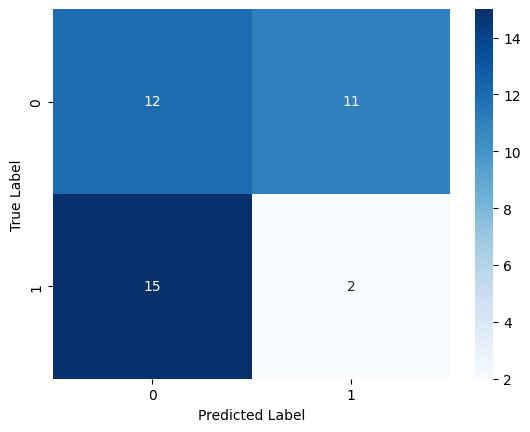

'Transcription: bonjour je suis content davoir étudié à did\nSentiment: negative'

In [20]:
def main():

    print("Training ...")
    N_EPOCHS = 3 
    LR = 5e-6
    epsilon=1e-08
    BATCH_SIZE = 64
    MAX_LENGTH = 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

    train_dataset = AllocineReviewsDataset(csv_file="data-allocine-french-movie-reviews/train.csv", device=device, max_length=MAX_LENGTH)
    test_dataset = AllocineReviewsDataset(csv_file="data-allocine-french-movie-reviews/test.csv", device=device, max_length=MAX_LENGTH)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

    model = SentimentAnalysisBert()
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=LR, eps=epsilon)

    for epoch in range(N_EPOCHS):
        loss_train = training_step(model, train_loader, loss_fn, optimizer)
        loss_eval, accuracy, all_preds, all_labels = evaluation_step(model, test_loader, loss_fn)


        print(
            f"Train Loss : {loss_train} | Eval Loss : {loss_eval} | Accuracy : {accuracy}"
        )  


    # Evaluation finale pour la matrice de confusion
    loss_eval, accuracy, all_preds, all_labels = evaluation_step(model, test_loader, loss_fn)
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
        

    
    # sauvegarde model
    torch.save(model.state_dict(), "CarelBrian_ASR_Camembert_SentimentAnalysis.pth")

    # Partie audio et transcription
    file_path = "C:/Users/USER/Documents/Audacity/dit.wav"  
    speech_array = load_and_preprocess_audio(file_path)
    transcription = predict_transcription(speech_array)

    # Analyse de sentiment sur la transcription
    sentiment = analyze_sentiment(model, tokenizer, transcription, device)
    display(f"Transcription: {transcription}\nSentiment: {sentiment}")
    
        



if __name__=="__main__":
    main()
